# Ducktile
## Introduction to TileDB and DuckDB

## TileDB

In [8]:
import pandas as pd
import tiledb
import numpy as np

# Define the maximum value for int64
max_int64 = np.iinfo(np.int64).max
tile_extent = 1000

# Calculate the safe domain max to avoid overflow
# Ensure domain_max + tile_extent <= max_int64
safe_domain_max = max_int64 - tile_extent

# Define the domain and schema for a sparse array
dom = tiledb.Domain(
    tiledb.Dim(name="timestamp", domain=(0, safe_domain_max), tile=tile_extent, dtype=np.int64),
    tiledb.Dim(name="latitude", domain=(-90.0, 90.0), tile=1.0, dtype=np.float64),
    tiledb.Dim(name="longitude", domain=(-180.0, 180.0), tile=1.0, dtype=np.float64),
    tiledb.Dim(name="altitude", domain=(0, 10000), tile=100, dtype=np.float64)
)

schema = tiledb.ArraySchema(
    domain=dom, sparse=True, attrs=[tiledb.Attr(name="temperature", dtype=np.float32)]
)

# Create the array
array_name = "temperature_data"
tiledb.SparseArray.create(array_name, schema)


TileDBError: [TileDB::StorageManager] Error: Cannot create array; Array 'file:///Users/faris/workspace/projects/faris/ducktiles/temperature_data' already exists

In [10]:
# Sample data
timestamps = np.array([1622505600, 1622592000, 1622678400], dtype=np.int64)  # Unix timestamps
latitudes = np.array([40.7128, 40.7128, 40.7128], dtype=np.float64)  # New York City latitude
longitudes = np.array([-74.0060, -74.0060, -74.0060], dtype=np.float64)  # New York City longitude
altitudes = np.array([10, 10, 10], dtype=np.float64)  # Altitude in meters
temperatures = np.array([22.5, 23.0, 21.5], dtype=np.float32)  # Temperatures in Celsius

# Write data to the array
with tiledb.SparseArray(array_name, mode='w') as A:
    A[timestamps, latitudes, longitudes, altitudes] = {"temperature": temperatures}


In [11]:
# Define the time range and location for the query
start_time = 1622505600
end_time = 1622678400
latitude = 40.7128
longitude = -74.0060
altitude = 10

# Query the array
with tiledb.SparseArray(array_name, mode='r') as A:
    data = A.query(attrs=["temperature"]).multi_index[start_time:end_time, latitude, longitude, altitude]
    df = pd.DataFrame({
        "timestamp": data["timestamp"],
        "temperature": data["temperature"]
    })
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')
    print(df)


   timestamp  temperature
0 2021-06-01         22.5
1 2021-06-02         23.0
2 2021-06-03         21.5


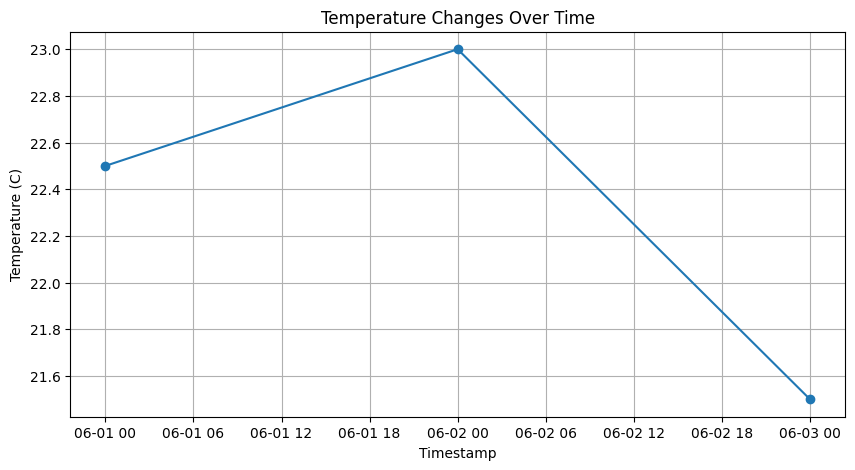

In [12]:
import matplotlib.pyplot as plt

# Plot the temperature changes over time
plt.figure(figsize=(10, 5))
plt.plot(df["timestamp"], df["temperature"], marker='o')
plt.title("Temperature Changes Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (C)")
plt.grid(True)
plt.show()
